In [1]:
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad

# Load and preprocess

In [2]:
adata = ad.read_h5ad("results/blastocyst_counts.transcript_based.transcript_name.annotated.filtered.h5ad")
print("Before filtering:", adata.shape)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X
sc.pp.log1p(adata)
print("No. of cells:", len(adata))

Before filtering: (2535, 73649)
No. of cells: 2529


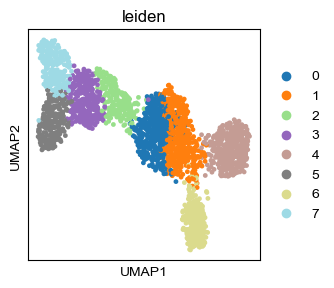

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(adata, color="leiden", palette="tab20")

# Assignment of cell-type

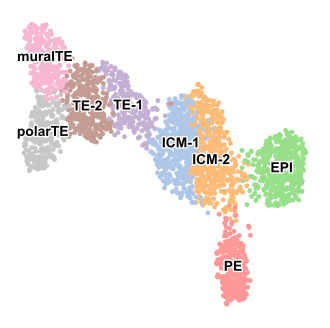

In [4]:
adata.obs["CellType"] = adata.obs["leiden"].map({
    "0": "ICM-1",
    "1": "ICM-2",
    "4": "EPI",
    "6": "PE",
    "2": "TE-1", 
    "3": "TE-2",
    "7": "muralTE",
    "5": "polarTE",
})
cmap = plt.colormaps["tab20"]
palette = {
    "ICM-1": cmap(1), 
    "ICM-2": cmap(3),
    "EPI": cmap(5),
    "PE": cmap(7),
    "TE-1": cmap(9),
    "TE-2": cmap(11),
    "muralTE": cmap(13),
    "polarTE": cmap(15)
}
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color="CellType", palette=palette, frameon=False, size=50, title="",
        legend_loc="on data", legend_fontoutline=2, ax=plt.gca(), save="_of_celltype_transcript_based.pdf")

# Plot cel-type markers

In [5]:
markers = [
    "Sox2-201", "Tdgf1-201", "Fgf4-201",
    "Sox17-201", "Sox17-204", "Gata6-201", 
    "Cdx2-201", "Gata3-201", "Eomes-201", "Elf5-201",
    "BC051665-201", "H19-202"
]
order = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
fig = sc.pl.dotplot(adata, markers, "CellType", categories_order=order, dendrogram=False, figsize=(5, 2.5), return_fig=True)
fig.plot_x_padding = 0.5
fig.plot_y_padding = 0.5
fig.savefig("figures/dotplot_of_marker_transcript_based.pdf")

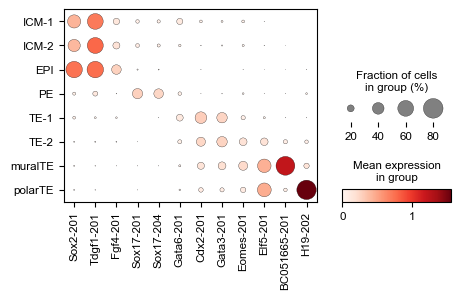

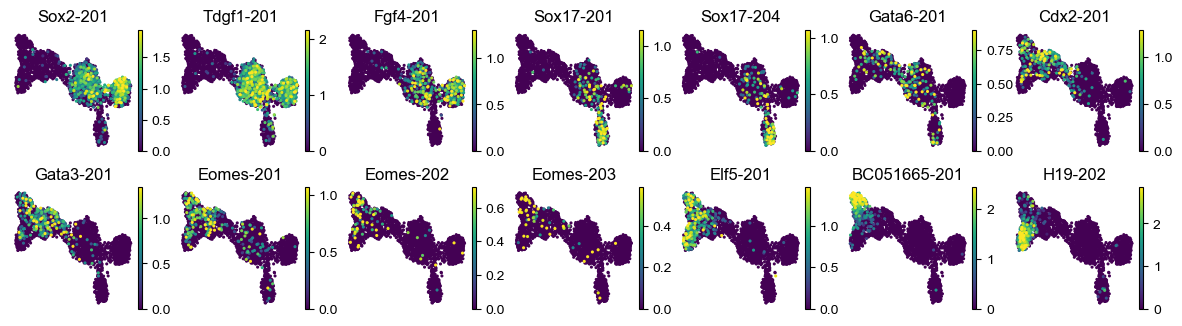

In [6]:
markers = [
    "Sox2-201", "Tdgf1-201", "Fgf4-201",
    "Sox17-201", "Sox17-204", "Gata6-201", 
    "Cdx2-201", "Gata3-201", "Eomes-201", "Eomes-202", "Eomes-203", "Elf5-201",
    "BC051665-201", "H19-202"
]
with plt.rc_context({"figure.figsize": (1.7, 1.7)}):
    fig = sc.pl.umap(adata, color=markers, s=20, frameon=False, ncols=7, vmax="p99", save="_of_marker_transcript_based.pdf", wspace=0.2, hspace=0.3)

# Differential expression

In [7]:
sc.tl.rank_genes_groups(adata, groupby="CellType", method="wilcoxon")
sc.tl.dendrogram(adata, groupby="CellType")

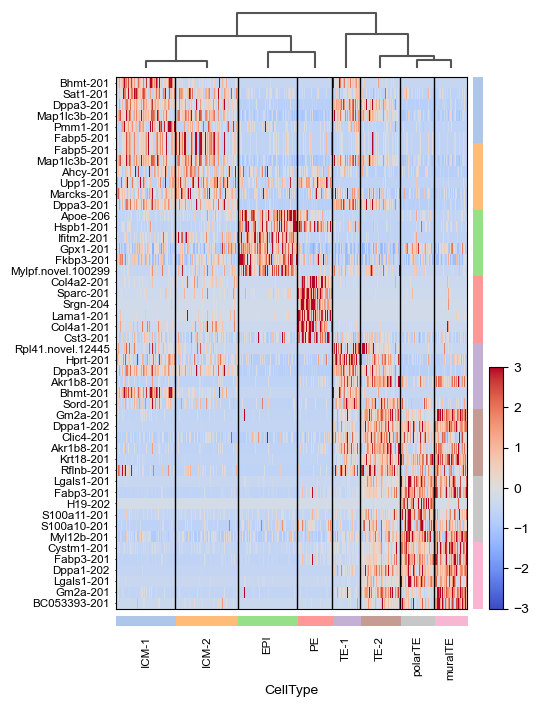

In [8]:
fig = sc.pl.rank_genes_groups_heatmap(
    adata, 
    n_genes=6, 
    use_raw=False, 
    groupby="CellType",
    swap_axes=True, 
    vmin=-3, 
    vmax=3, 
    cmap="coolwarm", 
    layer="scaled",
    figsize=(5, 8), 
    dendrogram=True,
    show_gene_labels=True,
    save="_transcript_based.pdf")

In [9]:
adata.write("results/scanpy_processed_transcript_based.h5ad", compression="gzip")

# Convert gene-based marker heatmap to transcript-based

In [57]:
adata1 = ad.read_h5ad("results/scanpy_processed_gene_based.h5ad")
adata2 = ad.read_h5ad("results/scanpy_processed_transcript_based.h5ad")

In [67]:
# reordered
cts = ["PE", "EPI", "ICM-2", "ICM-1", "TE-1", "TE-2", "muralTE", "polarTE"]
adata1.obs["CellType"] = adata1.obs["CellType"].cat.reorder_categories(cts)
adata2.obs["CellType"] = adata2.obs["CellType"].cat.reorder_categories(cts)

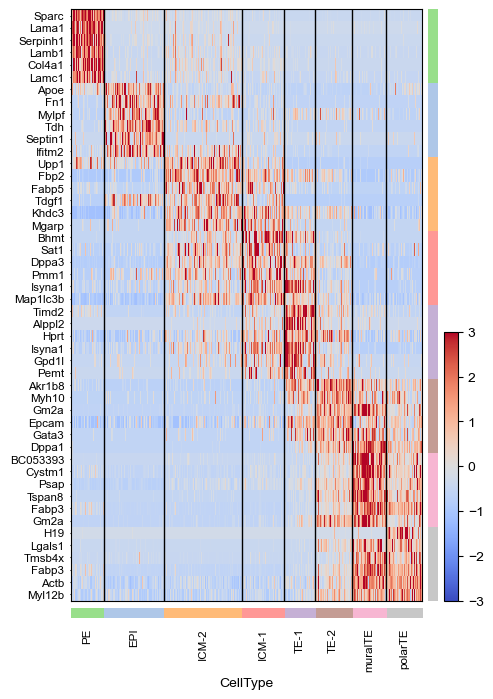

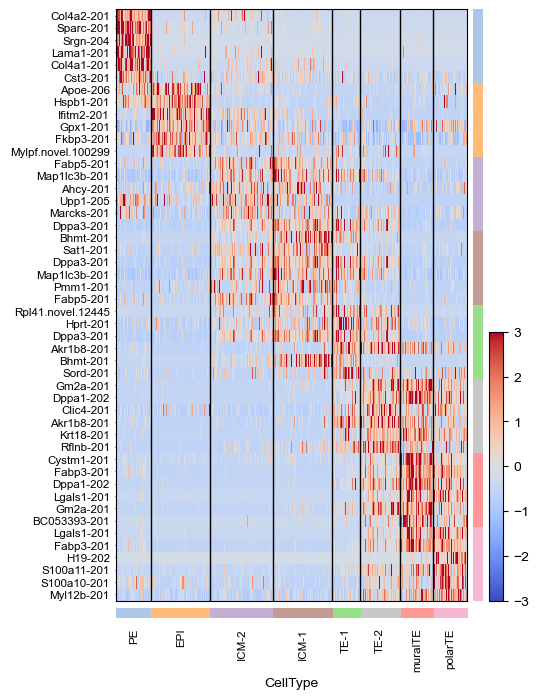

In [111]:
names = ["gene", "transcript"]
for i, adata in enumerate([adata1, adata2]):
    genes = dict()
    for ct in cts:
        genes[ct] = list(sc.get.rank_genes_groups_df(adata, group=ct).head(6)["names"])
    ax = sc.pl.heatmap(adata, genes, groupby="CellType", dendrogram=False, swap_axes=True, vmin=-3, vmax=3, cmap="coolwarm", layer="scaled", figsize=(5, 8), save="_degs_%s_based.pdf" % names[i])

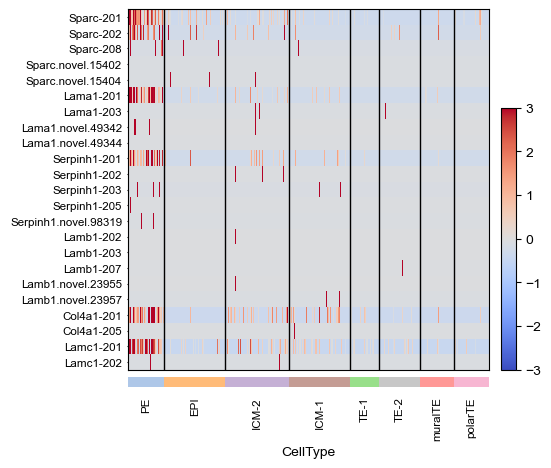

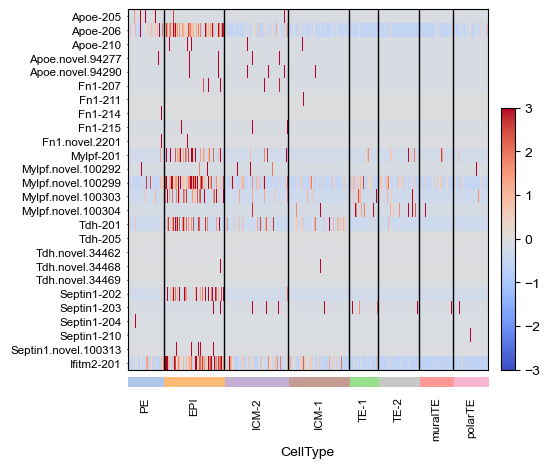

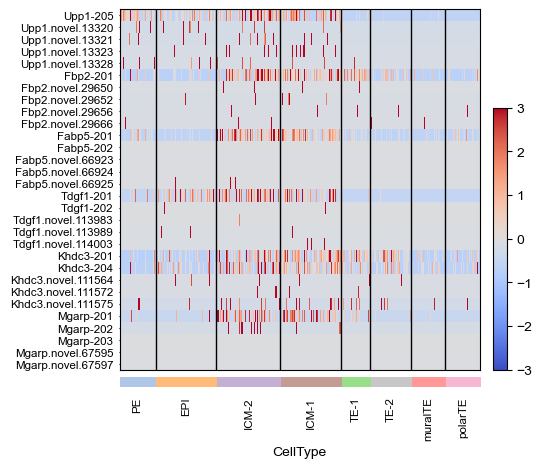

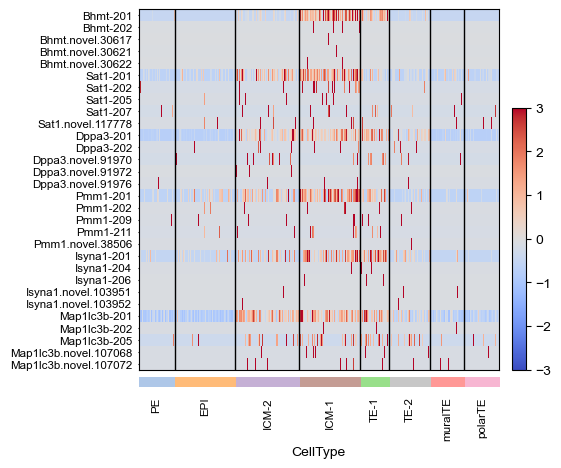

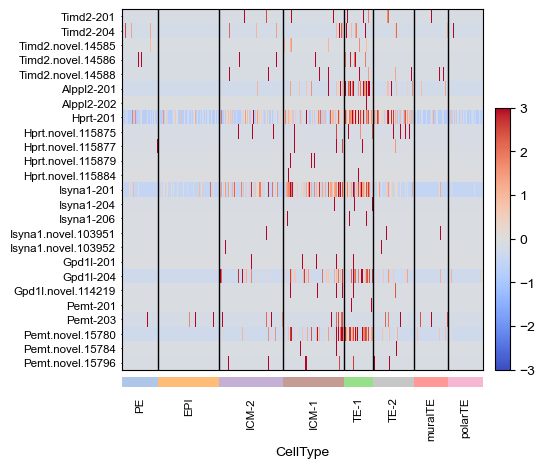

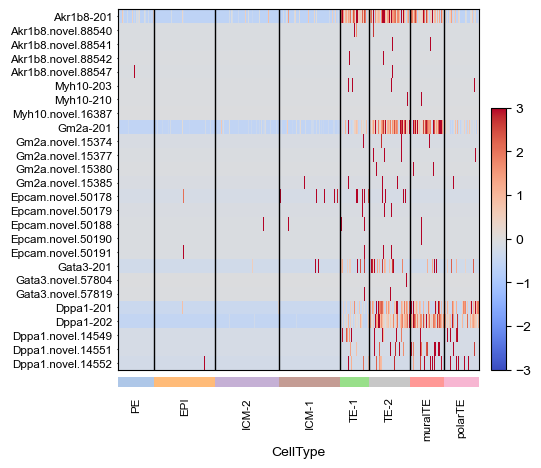

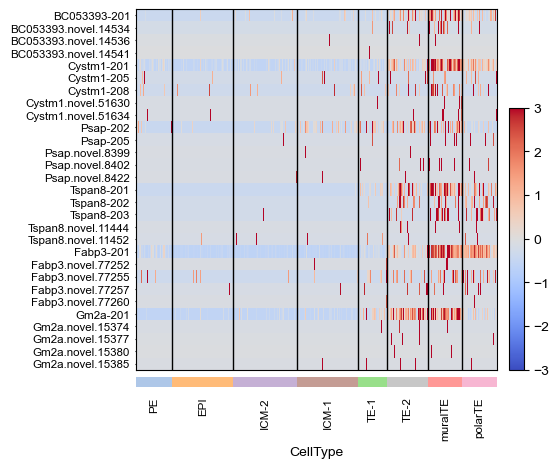

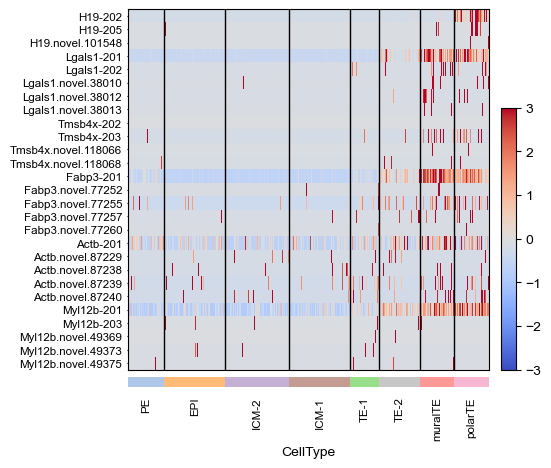

In [114]:
genes = dict()
for ct in cts:
    genes[ct] = list(sc.get.rank_genes_groups_df(adata1, group=ct).head(6)["names"])

for ct in cts:
    genes2 = list()
    for g1 in genes[ct]:
        tmp = adata2.var
        tmp = tmp[tmp["GeneName"] == g1]
        tmp = tmp.sort_values(by="n_cells", ascending=False)
        #tmp = tmp[tmp["n_cells"] > 3]
        tmp = tmp.head(5)
        genes2.extend(list(sorted(tmp.index)))
    ax = sc.pl.heatmap(adata2, genes2, groupby="CellType", dendrogram=False, 
                       swap_axes=True, layer="scaled", 
                       vmin=-3, vmax=3, cmap="coolwarm", 
                       show_gene_labels=True, figsize=(5, 5), save="_of_gene_based_markers_at_transcript_based.%s.pdf" % ct)
    # break